In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pvlib
from pvlib import iotools, location
from pvlib.irradiance import get_total_irradiance
from pvlib.pvarray import pvefficiency_adr

In [13]:
PVLIB_DIR = pvlib.__path__[0]
DATA_FILE = os.path.join(PVLIB_DIR, "data", "723170TYA.CSV")

tmy, metadata = iotools.read_tmy3(DATA_FILE, coerce_year=1990, map_variables=True)

df = pd.DataFrame(
    {
        "ghi": tmy["ghi"],
        "dhi": tmy["dhi"],
        "dni": tmy["dni"],
        "temp_air": tmy["temp_air"],
        "wind_speed": tmy["wind_speed"],
    }
)

In [3]:
df

,ghi,dhi,dni,temp_air,wind_speed
1990-01-01 01:00:00-05:00,0,0,0,10.0,6.2
1990-01-01 02:00:00-05:00,0,0,0,10.0,5.2
1990-01-01 03:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 04:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 05:00:00-05:00,0,0,0,10.0,5.2
...,...,...,...,...,...
1990-12-31 20:00:00-05:00,0,0,0,2.8,2.6
1990-12-31 21:00:00-05:00,0,0,0,2.8,2.6
1990-12-31 22:00:00-05:00,0,0,0,2.8,2.1
1990-12-31 23:00:00-05:00,0,0,0,2.8,2.6


In [4]:
df.index = df.index - pd.Timedelta(minutes=30)

loc = location.Location.from_tmy(metadata)
solpos = loc.get_solarposition(df.index)

TILT = metadata["latitude"]
ORIENT = 180

total_irrad = get_total_irradiance(
    TILT, ORIENT, solpos.apparent_zenith, solpos.azimuth, df.dni, df.ghi, df.dhi
)

df["poa_global"] = total_irrad.poa_global

df["temp_pv"] = pvlib.temperature.faiman(df.poa_global, df.temp_air, df.wind_speed)

adr_params = {
    "k_a": 0.99924,
    "k_d": -5.49097,
    "tc_d": 0.01918,
    "k_rs": 0.06999,
    "k_rsh": 0.26144,
}

df["eta_rel"] = pvefficiency_adr(df["poa_global"], df["temp_pv"], **adr_params)

# Set the desired array size:
P_STC = 5000.0  # (W)

# and the irradiance level needed to achieve this output:
G_STC = 1000.0  # (W/m2)

df["p_mp"] = P_STC * df["eta_rel"] * (df["poa_global"] / G_STC)

In [9]:
import pvdeg

weather_df = df
meta = metadata

In [12]:
def dc_output(weather_df, meta):
    solpos = pvdeg.spectral.solar_position(weather_df=weather_df, meta=meta)

    # Define panel orientation
    tilt, orient = 25, 180

    # Compute plane-of-array (POA) irradiance
    total_irrad = get_total_irradiance(
        tilt,
        orient,
        solpos.apparent_zenith,
        solpos.azimuth,
        weather_df.dni,
        weather_df.ghi,
        weather_df.dhi,
    )
    weather_df["poa_global"] = total_irrad.poa_global

    # Estimate PV module temperature
    weather_df["temp_pv"] = pvlib.temperature.faiman(
        weather_df.poa_global, weather_df.temp_air, weather_df.wind_speed
    )

    # ADR model parameters
    adr_params = {
        "k_a": 0.99924,
        "k_d": -5.49097,
        "tc_d": 0.01918,
        "k_rs": 0.06999,
        "k_rsh": 0.26144,
    }

    # Compute efficiency
    weather_df["eta_rel"] = pvefficiency_adr(
        weather_df.poa_global, weather_df.temp_pv, **adr_params
    )

    # Compute power output
    P_STC, G_STC = 5000.0, 1000.0  # Standard conditions (W, W/m²)
    weather_df["p_mp"] = P_STC * weather_df.eta_rel * (weather_df.poa_global / G_STC)

    return weather_df[["p_mp", "eta_rel"]]

In [16]:
import pandas as pd
import xarray as xr

geo_weather = xr.open_dataset("small-usa-tmy.nc")
geo_meta = pd.read_csv("small-us-tmy.csv", index_col=0)

In [23]:
geo_weather

<xarray.Dataset> Size: 33MB
Dimensions:            (time: 8760, gid: 79)
Coordinates:
  * gid                (gid) int64 632B 150803 150883 150963 ... 1260496 1364159
  * time               (time) datetime64[ns] 70kB 2023-01-01T00:30:00 ... 202...
Data variables:
    temp_air           (time, gid) float64 6MB ...
    wind_speed         (time, gid) float64 6MB ...
    dhi                (time, gid) float64 6MB ...
    ghi                (time, gid) float64 6MB ...
    dni                (time, gid) float64 6MB ...
    relative_humidity  (time, gid) float64 6MB ...

In [47]:
def offset_to_gmt(offset):
    sign = "+" if offset <= 0 else "-"
    return f"Etc/GMT{sign}{abs(offset)}"


def NSRDB_localize(weather_df, meta):
    zone_str = offset_to_gmt(meta["tz"])
    local_weather = weather_df.tz_localize("gmt").tz_convert(zone_str)
    return local_weather


@pvdeg.decorators.geospatial_quick_shape("timeseries", ["p_mp", "eta_rel"])
def dc_output(weather_df, meta):
    weather_df = NSRDB_localize(weather_df=weather_df, meta=meta)

    solpos = pvdeg.spectral.solar_position(weather_df=weather_df, meta=meta)

    # Define panel orientation
    tilt, orient = 25, 180

    # Compute plane-of-array (POA) irradiance
    total_irrad = get_total_irradiance(
        tilt,
        orient,
        solpos.apparent_zenith,
        solpos.azimuth,
        weather_df.dni,
        weather_df.ghi,
        weather_df.dhi,
    )
    weather_df["poa_global"] = total_irrad.poa_global

    # Estimate PV module temperature
    weather_df["temp_pv"] = pvlib.temperature.faiman(
        weather_df.poa_global, weather_df.temp_air, weather_df.wind_speed
    )

    # ADR model parameters
    adr_params = {
        "k_a": 0.99924,
        "k_d": -5.49097,
        "tc_d": 0.01918,
        "k_rs": 0.06999,
        "k_rsh": 0.26144,
    }

    # Compute efficiency
    weather_df["eta_rel"] = pvefficiency_adr(
        weather_df.poa_global, weather_df.temp_pv, **adr_params
    )

    # Compute power output
    P_STC, G_STC = 5000.0, 1000.0  # Standard conditions (W, W/m²)
    weather_df["p_mp"] = P_STC * weather_df.eta_rel * (weather_df.poa_global / G_STC)

    return weather_df[["p_mp", "eta_rel"]].tz_convert("UTC").tz_convert(None)

In [48]:
res = pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=dc_output,
)

res

<xarray.Dataset> Size: 17MB
Dimensions:    (latitude: 7, longitude: 17, time: 8760)
Coordinates:
  * latitude   (latitude) float64 56B 27.85 31.05 34.25 37.45 40.65 43.85 47.05
  * longitude  (longitude) float64 136B -121.5 -118.3 -115.1 ... -73.5 -70.3
  * time       (time) datetime64[ns] 70kB 2023-01-01T00:30:00 ... 2023-12-31T...
Data variables:
    p_mp       (time, latitude, longitude) float64 8MB nan nan nan ... nan nan
    eta_rel    (time, latitude, longitude) float64 8MB nan nan nan ... nan nan

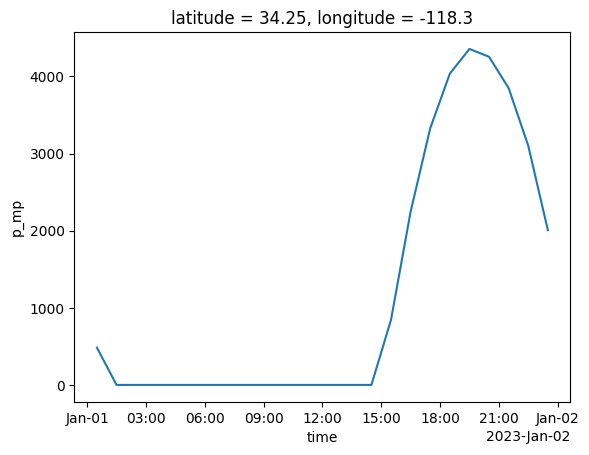

In [55]:
res.isel(latitude=2, longitude=1).head(24)["p_mp"].plot()

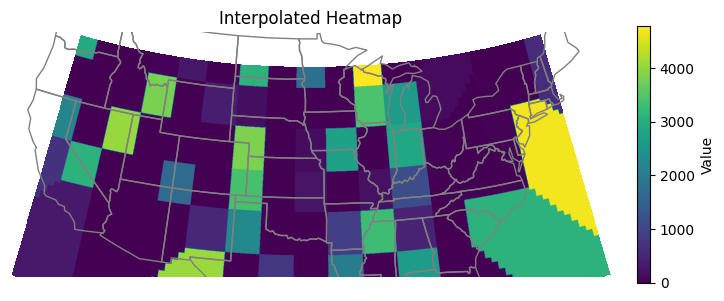

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': 'Interpolated Heatmap'}, xlabel='Longitude', ylabel='Latitude'>)

In [56]:
pvdeg.geospatial.plot_sparse_analysis(result=res, data_var="p_mp")

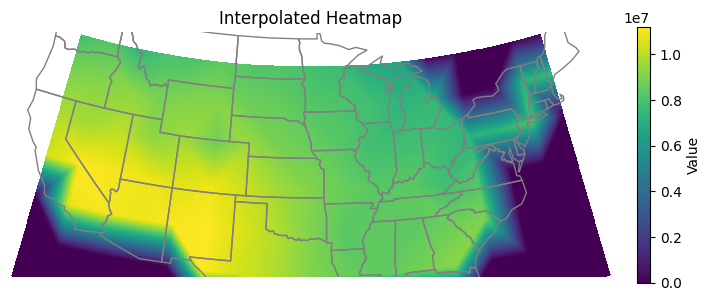

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': 'Interpolated Heatmap'}, xlabel='Longitude', ylabel='Latitude'>)

In [60]:
pvdeg.geospatial.plot_sparse_analysis(
    result=res.sum(dim="time"), data_var="p_mp", method="linear", resolution=200j
)